# autonomous vehicles

In [5]:
from gurobipy import *
import numpy as np
import time
import sys
# import sources.deepc
from vehicle import Car
import matplotlib.pyplot as plt
print(sys.path)

['C:\\Users\\nesto\\OneDrive\\Documentos\\GitHub\\Thesis-Nestor\\Python', 'C:\\Users\\nesto\\OneDrive\\Documentos\\GitHub\\Thesis-Nestor', 'C:\\Users\\nesto\\anaconda3\\python37.zip', 'C:\\Users\\nesto\\anaconda3\\DLLs', 'C:\\Users\\nesto\\anaconda3\\lib', 'C:\\Users\\nesto\\anaconda3', '', 'C:\\Users\\nesto\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\nesto\\AppData\\Roaming\\Python\\Python37\\site-packages\\win32', 'C:\\Users\\nesto\\AppData\\Roaming\\Python\\Python37\\site-packages\\win32\\lib', 'C:\\Users\\nesto\\AppData\\Roaming\\Python\\Python37\\site-packages\\Pythonwin', 'C:\\Users\\nesto\\anaconda3\\lib\\site-packages', 'C:\\Users\\nesto\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\nesto\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\nesto\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\nesto\\AppData\\Roaming\\Python\\Python37\\site-packages\\IPython\\extensions', 'C:\\Users\\nesto\\.ipython', 'C:\\Program Files\\JetBrains\\PyCharm

In [6]:
nx = 1  # Number of agents
nu = 1  # Number of inputs
nv = 2  #numero de vehiculos sin el agente no cooperativo
# MPC data
Q = 1  #* np.identity(1)
R = 10  #* np.identity(1)
N = 7  #horizon
dt = 0.1  #[s]
Ds = 7  #Safety distance [m]
Dl = 25  #lateral distance
V_max = 80
A_max = 30
L = 6  #number of lanes
Mmax = L - 1
mmin = -L + 1
p_max = 1


In [7]:
m = Model('vehicle')


Academic license - for non-commercial use only - expires 2021-05-16
Using license file C:\Users\nesto\gurobi.lic


In [8]:
#------------desired states-----------
Zd = m.addVar(lb=0, ub=L, vtype=GRB.INTEGER, name='Zd')  #carril deseado
Vd = m.addVar(lb=0, ub=V_max, vtype=GRB.CONTINUOUS, name='Vd')  #velocidad deseada
DS = m.addVar(vtype=GRB.CONTINUOUS, name='Ds')  #velocidad deseada
# m.addVar


# -------------local vehicle---------------
v = m.addVars(N + 1, lb=0, ub=V_max, vtype=GRB.CONTINUOUS, name='v')  #velocidad del vehiculo actual

In [9]:
a = m.addVars(N, lb=-A_max, ub=A_max, vtype=GRB.CONTINUOUS, name='a')  #aceleracion actual del vehiculo
z = m.addVars(N + 1, lb=1, ub=L, vtype=GRB.INTEGER, name='z')  #carril actual
ll = m.addVars(N, vtype=GRB.BINARY, name='ll')  #paso izquierda
lr = m.addVars(N, vtype=GRB.BINARY, name='lr')  #paso derecha
# -------------- neighbor ---------------
lr2 = m.addVar(vtype=GRB.BINARY, name='lr2')  #paso derecha
v_2 = m.addVar(vtype=GRB.CONTINUOUS, name='v_2')  #velocidad del otro vehculo
z_2 = m.addVar(lb=1, ub=L, vtype=GRB.INTEGER, name='z_2')  #carril del vehiculo j
# ------ distance between two vehicles ------
dis12 = m.addVars(N + 1,lb=-10000, ub=10000, vtype=GRB.CONTINUOUS, name='dis12')  #distancia entre vehiculo 1 y 2


In [10]:
a12 = m.addVars(N, vtype=GRB.BINARY, name="a12")
b12 = m.addVars(N, vtype=GRB.BINARY, name="b12")
ab12 = m.addVars(N, vtype=GRB.BINARY, name="ab12")
n12 = m.addVars(N, vtype=GRB.BINARY, name="n12")
th12 = m.addVars(N, vtype=GRB.BINARY, name="th12")
f12 = m.addVars(N, vtype=GRB.BINARY, name="f12")
g12 = m.addVars(N, vtype=GRB.BINARY, name="g12")
h12 = m.addVars(N, vtype=GRB.BINARY, name="h12")

In [11]:
m.setObjective(quicksum(Q * (v[k + 1] - Vd) ** 2 + R * (z[k + 1] - Zd) ** 2 for k in range(N)), GRB.MINIMIZE)


In [12]:
#Create local constraints
m.addConstrs(z[k] - lr[k] <= z[k + 1] for k in range(N))
m.addConstrs(z[k + 1] <= z[k] + ll[k] for k in range(N))

m.addConstrs(ll[k] + lr[k] <= 1 for k in range(N))
m.addConstrs(v[k + 1] == v[k] + dt * a[k] for k in range(N))

m.addConstrs( mmin  <= z_2-z[k+1] for k in range(N))
m.addConstrs(z_2-z[k+1]  <= Mmax for k in range(N))

m.addConstrs( (dis12[k + 1] == dis12[k] + dt * (v_2 - v[k]) for k in range(N)), name="distance" )



{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>}

In [14]:
z[:] - z_2

TypeError: 'int' object is not subscriptable

In [42]:

# %------condiciones iniciales----------
vel = np.array([20, 20])  # velociodad inicial
Vdes = np.array([30, 50])  # velocidad deseada

zel = np.array([5, 4])  # carril inicial
Zdes = np.array([1, 1])  # carril deseado

acel = np.array([0, 0])
# %---distancia inicial de cada agente
d1i = np.array([-50])
i = 0
zel2 = zel  #same dimentions
LR2 = 1
LR1 = 1

In [43]:
# res =m.getVarByName(name="v")
# v.x

# create the model
vh1 = Car(vel[0], zel[0], Vdes[0], Zdes[0], N, name="vehiculo_1")
vh2 = Car(vel[1], zel[1], Vdes[1], Zdes[1], N, name="vehiculo_2")



In [44]:

%%time
vh1.create_model()
vh2.create_model()
# cnt_z = m.addConstr(z[0] == zel[0], name="Z[0]")
# cnt_v = m.addConstr(v[0] == vel[0])
# cnt_zd = m.addConstr(Zd == Zdes[0])
# cnt_vd = m.addConstr(Vd == Vdes[0])
# cnt_v2 = m.addConstr(v_2 == vel[1])
# cnt_z2 = m.addConstr(z_2 == zel[1])
# cnt_d = m.addConstr(dis12[0] == d1i[0])
# cnt_lr = m.addConstr(lr2 == LR2)
vh1.m.update()
vh2.m.update()
# vh1.m.display()

Wall time: 3 ms


In [45]:
%%capture --no-stderr
t = time.time()
sim_tim = 20
for k in range(sim_tim):
    # cnt_z.rhs = zel[0]
    # cnt_v.rhs = vel[0]
    # cnt_zd.rhs = Zdes[0]
    # cnt_vd.rhs = Vdes[0]
    # cnt_v2.rhs = vel[1]
    # cnt_z2.rhs = zel[1]
    # cnt_d.rhs = d1i[0]
    vh1.update_cnt(zel[0],vel[0],Zdes[0],Vdes[0],vel[1],zel[1],d1i[0])
    vh1.m.update()
    vh1.m.optimize()
    vh2.update_cnt(zel[1],vel[1],Zdes[1],Vdes[1],vel[0],zel[0],-d1i[0])
    vh2.m.update()
    vh2.m.optimize()

    # get optimal solution
    acel[0], zel[0] = vh1.get_var(N)
    acel[1], zel[1] = vh2.get_var(N)


    vel[0], zel[0] = vh1.make_step(acel[0],zel[0])
    vel[1], zel[1] = vh2.make_step(acel[1],zel[1])

    d1i = d1i + dt*(vel[1:]-vel[0])


elapsed = time.time() - t

In [46]:
print("Elapsed time: {}[s]".format(round(elapsed,3)))
print("the objective function is :" + str(round(vh1.m.ObjVal, 2)))
for v in vh1.m.getVars():
    print(str(v.VarName), v.x)






Elapsed time: 0.06[s]
the objective function is :0.0
Zd 1.0
Vd 30.0
v[0] 30.0
v[1] 30.0
v[2] 30.0
v[3] 30.0
v[4] 30.0
v[5] 30.0
v[6] 30.0
v[7] 30.0
a[0] 0.0
a[1] 0.0
a[2] 0.0
a[3] 0.0
a[4] 0.0
a[5] 0.0
a[6] 0.0
z[0] 1.0
z[1] 1.0
z[2] 1.0
z[3] 1.0
z[4] 1.0
z[5] 1.0
z[6] 1.0
z[7] 1.0
ll[0] 1.0
ll[1] 1.0
ll[2] 1.0
ll[3] 1.0
ll[4] 1.0
ll[5] 1.0
ll[6] 1.0
lr[0] 0.0
lr[1] 0.0
lr[2] 0.0
lr[3] 0.0
lr[4] 0.0
lr[5] 0.0
lr[6] 0.0
v_2 50.0
z_2 1.0
dis12[0] -25.0
dis12[1] -23.0
dis12[2] -21.0
dis12[3] -19.0
dis12[4] -17.0
dis12[5] -15.0
dis12[6] -13.0
dis12[7] -11.0


In [47]:

historial_vel = vh1.hist_zp1

In [48]:
hist_pred_z1 = np.array(vh1.hist_zp1)
hist_pred_z2 = np.array(vh2.hist_zp1)
hist_pred_v1 = np.array(vh1.hist_vp1)
hist_pred_v2 = np.array(vh2.hist_vp1)
hist_time = np.arange(0,sim_tim)
hist_pred_v2.shape

(20, 7)

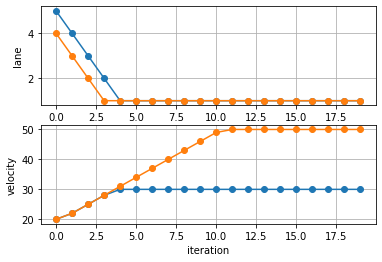

In [49]:
# plot the data
# fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(2, 1)
# ax = fig.add_subplot(2, 1, 1)
ax1.plot(hist_time,hist_pred_z1[:,0], marker='o' , color='tab:blue')
ax1.plot(hist_time,hist_pred_z2[:,0], marker='o' , color='tab:orange')
ax1.set_xlabel('iteration')
ax1.set_ylabel('lane')
ax1.grid(True)

ax2.plot(hist_time,hist_pred_v1[:,0], marker='o' , color='tab:blue')
ax2.plot(hist_time,hist_pred_v2[:,0], marker='o' , color='tab:orange')
ax2.set_xlabel('iteration')
ax2.set_ylabel('velocity')
ax2.grid(True)